# __Activity 3__
## Rachel Nana, November 2018

__Importing Packages__

In [1]:
import pandas as pd
import sklearn
import numpy as np

__Importing Telco Data__

In [2]:
telco = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv');

__Data Prep__

tenure: min and max

In [3]:
print(min(telco['tenure']))
print(max(telco['tenure']))

0
72


MonthlyCharges: min and max

In [4]:
print(min(telco['MonthlyCharges']))
print(max(telco['MonthlyCharges']))

18.25
118.75


TotalCharges: min and max

In [5]:
print(min(telco['TotalCharges'].replace(" ", 0).astype(float)))
print(max(telco['TotalCharges'].replace(" ", 0).astype(float)))

0.0
8684.8


normalizing

In [6]:
tenure_normalized = telco['tenure'].add(-36).divide(36)

In [7]:
print(min(tenure_normalized))
print(max(tenure_normalized))

-1.0
1.0


In [8]:
MonthlyCharges_normalized = telco['MonthlyCharges'].add(-68.5).divide(50.25)

In [9]:
print(min(MonthlyCharges_normalized))
print(max(MonthlyCharges_normalized))

-1.0
1.0


In [10]:
TotalCharges_normalized = telco['TotalCharges'].replace(" ", 0).astype(float).add(-4342.4).divide(4342.4)

In [11]:
print(min(TotalCharges_normalized))
print(max(TotalCharges_normalized))

-1.0
1.0


producing indicators

In [12]:
Male_ind = telco['gender'].eq('Male').mul(1)
Partner_ind = telco['Partner'].eq('Yes').mul(1)
Dependents_ind = telco['Dependents'].eq('Yes').mul(1)
PhoneService_ind = telco['PhoneService'].eq('Yes').mul(1)
MultipleLines_ind = telco['MultipleLines'].eq('Yes').mul(1)
FiberOptic_ind = telco.rename(columns={'InternetService':'FiberOptic'})['FiberOptic'].eq('Fiber optic').mul(1)
DSL_ind = telco.rename(columns={'InternetService':'DSL'})['DSL'].eq('DSL').mul(1)
OnlineSecurity_ind = telco['OnlineSecurity'].eq('Yes').mul(1)
OnlineBackup_ind = telco['OnlineBackup'].eq('Yes').mul(1)
DeviceProtection_ind = telco['DeviceProtection'].eq('Yes').mul(1)
TechSupport_ind = telco['TechSupport'].eq('Yes').mul(1)
StreamingTV_ind = telco['StreamingTV'].eq('Yes').mul(1)
StreamingMovies_ind = telco['StreamingMovies'].eq('Yes').mul(1)
Contract_dummies=pd.get_dummies(telco['Contract'], drop_first=True)
PaperlessBilling_ind = telco['PaperlessBilling'].eq('Yes').mul(1)
PaymentMethod_dummies=pd.get_dummies(telco['PaymentMethod'], drop_first=True)
Churn_ind = telco['Churn'].eq('Yes').mul(1)

features

In [13]:
X = pd.concat([Male_ind, telco['SeniorCitizen'], Partner_ind, Dependents_ind, tenure_normalized, PhoneService_ind, MultipleLines_ind, FiberOptic_ind, DSL_ind, OnlineSecurity_ind, OnlineBackup_ind, DeviceProtection_ind, TechSupport_ind, StreamingTV_ind, StreamingMovies_ind, Contract_dummies, PaperlessBilling_ind, PaymentMethod_dummies, MonthlyCharges_normalized, TotalCharges_normalized], axis=1)
print(X[:5])
print(X.shape)

   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -0.972222             0   
1       1              0        0           0 -0.055556             1   
2       1              0        0           0 -0.944444             1   
3       1              0        0           0  0.250000             0   
4       0              0        0           0 -0.944444             1   

   MultipleLines  FiberOptic  DSL  OnlineSecurity      ...       StreamingTV  \
0              0           0    1               0      ...                 0   
1              0           0    1               1      ...                 0   
2              0           0    1               1      ...                 0   
3              0           0    1               1      ...                 0   
4              0           1    0               0      ...                 0   

   StreamingMovies  One year  Two year  PaperlessBilling  \
0                0  

encoding

In [14]:
from sklearn import preprocessing
for column in X.columns:
    if X[column].dtype == type(object):
        le = preprocessing.LabelEncoder()
        X[column] = le.fit_transform(X[column])

dependent variable

In [15]:
y = Churn_ind
print(y[:5])
print(y.shape)

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int32
(7043,)


split the data

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Competing Models

__Model 1: Decision Tree__

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

parameter grid

In [18]:
tree_param_dist = {"criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "max_features": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None], 
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}

grid search

In [19]:
%%time
tree = DecisionTreeClassifier()
tree_grid_cv = GridSearchCV(tree, tree_param_dist, cv=10)
tree_grid_cv.fit(X_train,y_train);

Wall time: 36min


optimal parameters

In [20]:
print("Tuned Decision Tree Parameters: {}".format(tree_grid_cv.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 16, 'min_samples_split': 15}


train model

In [21]:
tree_grid = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features=16, min_samples_split=15)
tree_grid = tree_grid.fit(X_train, y_train)

tree visualization

In [22]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [23]:
dot_data = StringIO()
export_graphviz(tree_grid, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

graph.write_pdf("decision_tree.pdf")

True

predictions

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss

In [25]:
predictions_tree = tree_grid.predict_proba(X_test)
roc_score_tree = roc_auc_score(y_test, predictions_tree[:,1])
log_loss_tree = log_loss(y_test, predictions_tree[:,1], eps=1e-15)
print("ROC Score: {}".format(roc_score_tree))
print("Log Loss: {}".format(log_loss_tree))

ROC Score: 0.8372051197118221
Log Loss: 0.5547179035932377


ROC curve

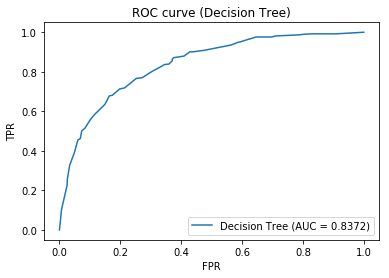

In [26]:
fpr_tree, tpr_tree, _ = roc_curve(y_test, predictions_tree[:,1])
plt.plot(fpr_tree, tpr_tree, label='Decision Tree (AUC = %0.4f)' % roc_score_tree)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Decision Tree)')
plt.show()

__Model 2: Naive Bayes__

In [27]:
from sklearn.naive_bayes import GaussianNB

train model

In [28]:
NB = GaussianNB()
NB.fit(X_train, y_train)

GaussianNB(priors=None)

predictions

In [29]:
predictions_NB = NB.predict_proba(X_test)
roc_score_NB = roc_auc_score(y_test, predictions_NB[:,1])
log_loss_NB = log_loss(y_test, predictions_NB[:,1], eps=1e-15)
print("ROC Score: {}".format(roc_score_NB))
print("Log Loss: {}".format(log_loss_NB))

ROC Score: 0.844456147070088
Log Loss: 0.9149028834669852


ROC curve

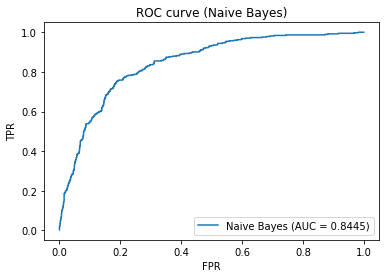

In [30]:
fpr_NB, tpr_NB, _ = roc_curve(y_test, predictions_NB[:,1])
plt.plot(fpr_NB, tpr_NB, label='Naive Bayes (AUC = %0.4f)' % roc_score_NB)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Naive Bayes)')
plt.show()

__Model 3: SVM__

In [31]:
from sklearn import svm

parameter grid

In [32]:
SVM_param_dist = {"C": [0.001, 0.01, 0.1, 1, 10], 
              "gamma": [0.001, 0.01, 0.1, 1], 
              "kernel": ["linear", "poly", "rbf", "sigmoid"],
              "degree": [2, 3, 4, 5]}

grid search

In [33]:
%%time
SVM = svm.SVC()
SVM_grid_cv = GridSearchCV(SVM, SVM_param_dist, cv=10)
SVM_grid_cv.fit(X_train,y_train);

Wall time: 2h 13min 36s


optimal parameters

In [34]:
print("Tuned SVM Parameters: {}".format(SVM_grid_cv.best_params_))

Tuned SVM Parameters: {'C': 0.01, 'degree': 2, 'gamma': 0.001, 'kernel': 'linear'}


train model

In [35]:
SVM_grid = svm.SVC(C=0.01, degree=2, gamma=0.001, kernel="linear", probability=True)
SVM_grid = SVM_grid.fit(X_train, y_train)

predictions

In [36]:
predictions_SVM = SVM_grid.predict_proba(X_test)
roc_score_SVM = roc_auc_score(y_test, predictions_SVM[:,1])
log_loss_SVM = log_loss(y_test, predictions_SVM[:,1], eps=1e-15)
print("ROC Score: {}".format(roc_score_SVM))
print("Log Loss: {}".format(log_loss_SVM))

ROC Score: 0.8532805593797551
Log Loss: 0.4083604982207678


ROC curve

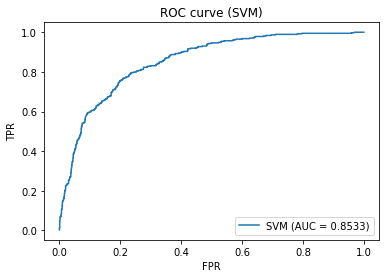

In [37]:
fpr_SVM, tpr_SVM, _ = roc_curve(y_test, predictions_SVM[:,1])
plt.plot(fpr_SVM, tpr_SVM, label='SVM (AUC = %0.4f)' % roc_score_SVM)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (SVM)')
plt.show()

__Model 4: K-Nearest Neighbors__

In [38]:
from sklearn.neighbors import KNeighborsClassifier

parameter grid

In [39]:
KNN_param_dist = {"n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              "weights": ["uniform", "distance"], 
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}

grid search

In [40]:
%%time
KNN = KNeighborsClassifier()
KNN_grid_cv = GridSearchCV(KNN, KNN_param_dist, cv=10)
KNN_grid_cv.fit(X_train,y_train);

Wall time: 16min 19s


optimal parameters

In [41]:
print("Tuned K-Nearest Neighbors Parameters: {}".format(KNN_grid_cv.best_params_))

Tuned K-Nearest Neighbors Parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'uniform'}


train model

In [42]:
KNN_grid = KNeighborsClassifier(algorithm="auto", n_neighbors=8, weights="uniform")
KNN_grid.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform')

predictions

In [43]:
predictions_KNN = KNN_grid.predict_proba(X_test)
roc_score_KNN = roc_auc_score(y_test, predictions_KNN[:,1])
log_loss_KNN = log_loss(y_test, predictions_KNN[:,1], eps=1e-15)
print("ROC Score: {}".format(roc_score_KNN))
print("Log Loss: {}".format(log_loss_KNN))

ROC Score: 0.8234302379744738
Log Loss: 0.8082345273884409


ROC curve

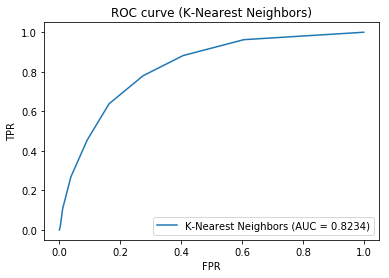

In [44]:
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, predictions_KNN[:,1])
plt.plot(fpr_KNN, tpr_KNN, label='K-Nearest Neighbors (AUC = %0.4f)' % roc_score_KNN)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (K-Nearest Neighbors)')
plt.show()

__Model 5: Random Forest__

In [45]:
from sklearn.ensemble import RandomForestClassifier

parameter grid

In [46]:
RF_param_dist = {"n_estimators": [5, 10, 20, 50, 100, 200], 
              "criterion": ["gini", "entropy"], 
              "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, None]}

grid search

In [47]:
%%time
RF = RandomForestClassifier()
RF_grid_cv = GridSearchCV(RF, RF_param_dist, cv=10)
RF_grid_cv.fit(X_train,y_train);

Wall time: 13min 28s


optimal parameters

In [48]:
print("Tuned Random Forest Parameters: {}".format(RF_grid_cv.best_params_))

Tuned Random Forest Parameters: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}


train model

In [49]:
RF_grid = RandomForestClassifier(criterion="gini", max_depth=9, n_estimators=200)
RF_grid.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

predictions

In [50]:
predictions_RF = RF_grid.predict_proba(X_test)
roc_score_RF = roc_auc_score(y_test, predictions_RF[:,1])
log_loss_RF = log_loss(y_test, predictions_RF[:,1], eps=1e-15)
print("ROC Score: {}".format(roc_score_RF))
print("Log Loss: {}".format(log_loss_RF))

ROC Score: 0.8632526628505182
Log Loss: 0.3993460827772721


ROC curve

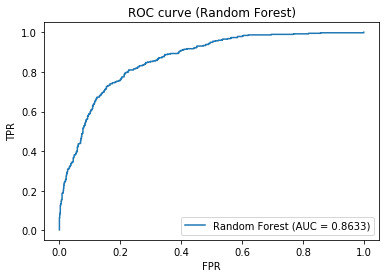

In [51]:
fpr_RF, tpr_RF, _ = roc_curve(y_test, predictions_RF[:,1])
plt.plot(fpr_RF, tpr_RF, label='Random Forest (AUC = %0.4f)' % roc_score_RF)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (Random Forest)')
plt.show()

__Model 6: XGBoost__

In [52]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

parameter grid

In [53]:
XGB_param_dist = {"n_estimators": [5, 10, 20, 50, 100, 200], 
                 "learning_rate": [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                 "subsample": [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                 "objective": ["reg:linear", "reg:logistic", "binary:logistic", "binary:logitraw"]}

grid search

In [54]:
%%time
XGB = xgb.XGBRegressor()
XGB_grid_cv = GridSearchCV(XGB, XGB_param_dist, cv=10)
XGB_grid_cv.fit(X_train,y_train);

Wall time: 1h 13min 33s


optimal parameters

In [55]:
print("Tuned XGBoost Parameters: {}".format(XGB_grid_cv.best_params_))

Tuned XGBoost Parameters: {'learning_rate': 0.3, 'n_estimators': 20, 'objective': 'reg:logistic', 'subsample': 1}


train model

In [56]:
XGB_grid = xgb.XGBRegressor(objective="reg:logistic", n_estimators=20 , learning_rate=0.3, subsample=1)
XGB_grid.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

predictions

In [57]:
predictions_XGB = XGB_grid.predict(X_test)
roc_score_XGB = roc_auc_score(y_test, predictions_XGB)
log_loss_XGB = log_loss(y_test, predictions_XGB, eps=1e-15)
print("ROC Score: {}".format(roc_score_XGB))
print("Log Loss: {}".format(log_loss_XGB))

ROC Score: 0.8627480410322232
Log Loss: 0.39749475025999537


ROC curve

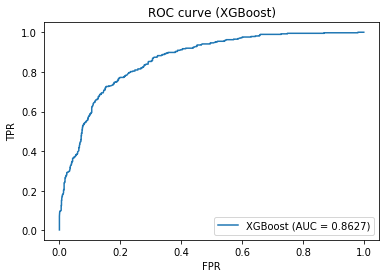

In [58]:
fpr_XGB, tpr_XGB, _ = roc_curve(y_test, predictions_XGB)
plt.plot(fpr_XGB, tpr_XGB, label='XGBoost (AUC = %0.4f)' % roc_score_XGB)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve (XGBoost)')
plt.show()

__Combined__

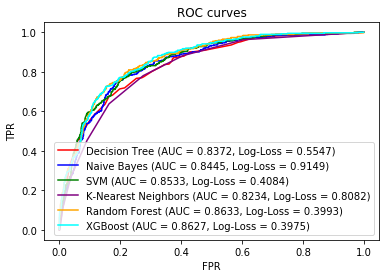

In [59]:
f = plt.figure()
plt.plot(fpr_tree, tpr_tree, color='red', label='Decision Tree (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_tree, log_loss_tree))
plt.plot(fpr_NB, tpr_NB, color='blue', label='Naive Bayes (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_NB, log_loss_NB))
plt.plot(fpr_SVM, tpr_SVM, color='green', label='SVM (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_SVM, log_loss_SVM))
plt.plot(fpr_KNN, tpr_KNN, color='purple', label='K-Nearest Neighbors (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_KNN, log_loss_KNN))
plt.plot(fpr_RF, tpr_RF, color='orange', label='Random Forest (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_RF, log_loss_RF))
plt.plot(fpr_XGB, tpr_XGB, color='aqua', label='XGBoost (AUC = %0.4f, Log-Loss = %0.4f)' % (roc_score_XGB, log_loss_XGB))
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curves')
plt.show()

f.savefig("ROC_curves.pdf", bbox_inches='tight')